In [14]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine


sys.path.append('../')

DB_URI = "postgresql+psycopg2://xodh3@localhost:5432/economy_db"
engine = create_engine(DB_URI)

print("🚀 분석 환경 준비 완료!")

🚀 분석 환경 준비 완료!


In [15]:
# 3. SQL로 QQQ와 GLD 데이터를 나란히 붙여서(Join) 가져오기
query = """
SELECT
    A.trade_date,
    A.close_price AS qqq,
    B.close_price AS gld
FROM practice_spy A
JOIN practice_spy B ON A.trade_date = B.trade_date
WHERE A.ticker = 'QQQ' AND B.ticker = 'GLD'
ORDER BY A.trade_date ASC;
"""
# 판다스 읽기
df = pd.read_sql(query, engine)
# 날짜를 인덱스 기준으로 설정하면 그래프 그리기 편함
df.set_index('trade_date', inplace=True)

print(f"✅ 데이터 로딩 완료: {len(df)}건")
df.head() # 상위 5개 눈으로 확인

✅ 데이터 로딩 완료: 251건


,qqq,gld
trade_date,,
2024-12-01,512.5582,243.44
2024-12-02,514.1298,243.93
2024-12-03,520.4860,244.67
2024-12-04,519.0436,242.86
2024-12-05,523.6889,242.95


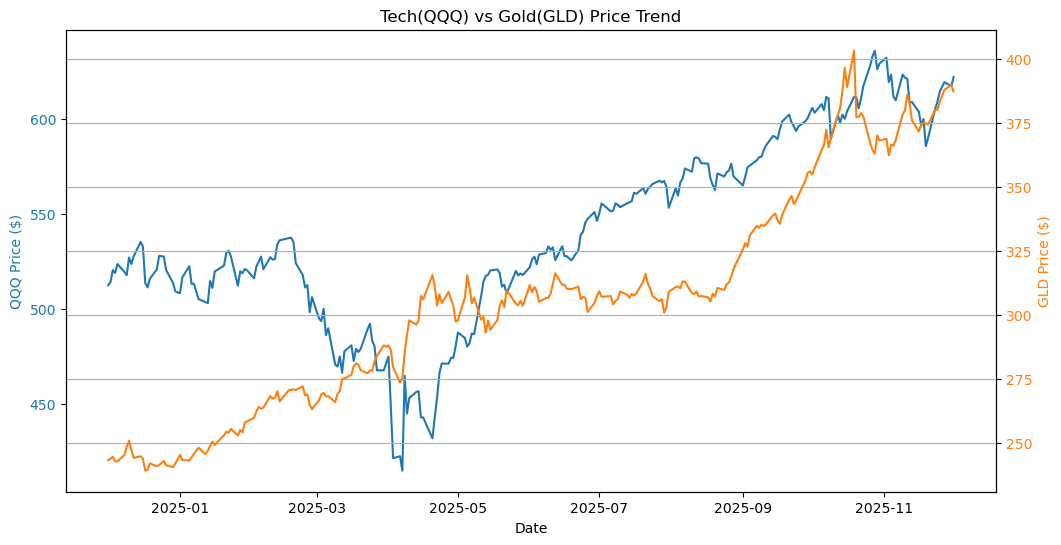

In [16]:
# 4. 그래프 그리기 (이중축 사용)
fig, ax1 = plt.subplots(figsize=(12, 6))

# 왼쪽 축: QQQ (파란색)
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('QQQ Price ($)', color=color)
ax1.plot(df.index, df['qqq'], color=color, label='QQQ (Tech)')
ax1.tick_params(axis='y', labelcolor=color)

# 오른쪽 축: GLD (금색)
ax2 = ax1.twinx()
color = 'tab:orange' # 금색이랑 비슷한 오렌지색
ax2.set_ylabel('GLD Price ($)', color=color)
ax2.plot(df.index, df['gld'], color=color, label='GLD (Gold)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Tech(QQQ) vs Gold(GLD) Price Trend')
plt.grid(True)
plt.show()

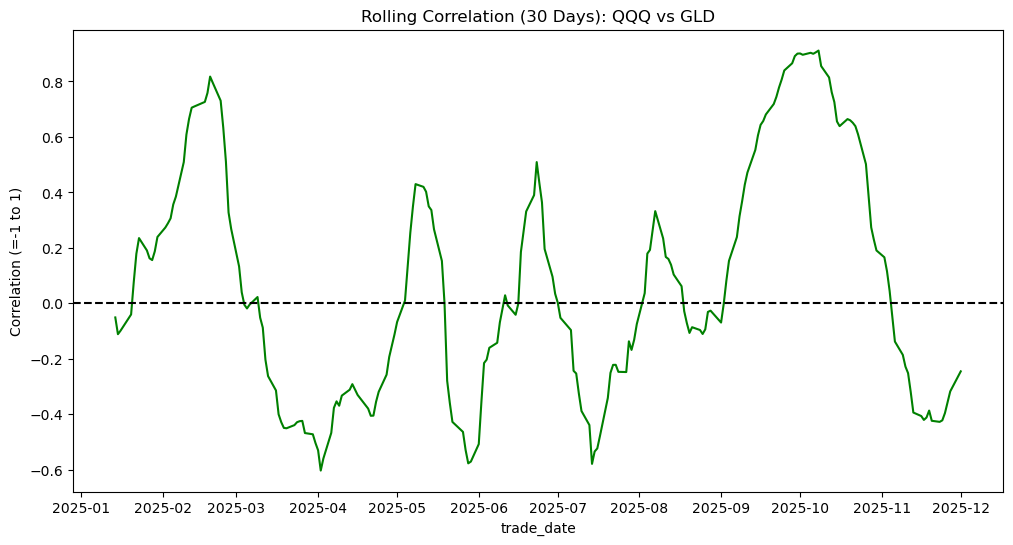

In [17]:
# 30일(약 한 달) 간격으로 둘의 관계가 어떻게 변했는지 계산
df['rolling_corr'] = df['qqq'].rolling(window=30).corr(df['gld'])

# 상관관계 변화 그래프 그리기
plt.figure(figsize=(12, 6))
df['rolling_corr'].plot(color='green')
plt.axhline(0, color= 'black', linestyle='--')
plt.title('Rolling Correlation (30 Days): QQQ vs GLD')
plt.ylabel('Correlation (=-1 to 1)')
plt.show()



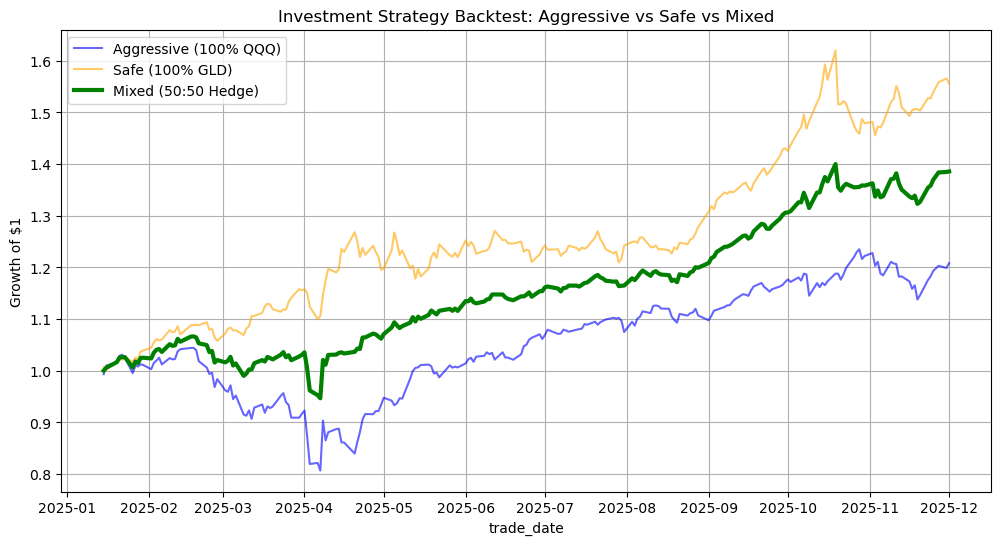

In [20]:
# 1. 일별 수익률 계산 (어제 대비 오늘 몇 % 올랐나?)
returns = df.pct_change().dropna()

# 2. 전략별 수익률 계산
returns['Strategy_Aggressive'] = returns['qqq']           # 100% 기술주
returns['Strategy_Safe'] = returns['gld']                 # 100% 금
returns['Strategy_Mixed'] = returns['qqq'] * 0.5 + returns['gld'] * 0.5  # 50:50 반반 전략

# 3. 누적 수익률 계산 (100만원 넣었으면 지금 얼마 됐나?)
# (1 + 수익률)을 계속 곱해주면 자산이 불어나는 게 보입니다.
cumulative_returns = (1 + returns).cumprod()

# 4. 그래프 그리기
plt.figure(figsize=(12, 6))
cumulative_returns['Strategy_Aggressive'].plot(label='Aggressive (100% QQQ)', color='blue', alpha=0.6)
cumulative_returns['Strategy_Safe'].plot(label='Safe (100% GLD)', color='orange', alpha=0.6)
cumulative_returns['Strategy_Mixed'].plot(label='Mixed (50:50 Hedge)', color='green', linewidth=3) # 주인공은 두껍게!

plt.title('Investment Strategy Backtest: Aggressive vs Safe vs Mixed')
plt.legend()
plt.grid(True)
plt.ylabel('Growth of $1')
plt.show()

/opt/anaconda3/envs/mymy/bin/python
